## Starting to make a more generic G-Code library for 2429 tools 2022 2010 CJH
* made a library called simplegcode
* user just generates the points and tells the code which machine they want
  * shapeoko brute force plunges all drilling
  * benchmill uses a G82 (spot drill) or G83 (peck drill) cycle
* has functions 
  * generate_gcode() to get the gcode and
  * plot_points() to get a plot of the points


In [154]:
import simplegcode as sg
import pandas as pd
import numpy as np
from importlib import reload

#### simple way to generate a grid or perimeter - you can also override and put in arbitrary points

In [206]:
# simple way to generate a grid
perimeter_only = True
x_start, x_final, x_spacing  = 0.5, 2.5, 1.0
y_start, y_final, y_spacing  = 0.5, 4.5, 1.0    

if perimeter_only:  # simple way to generate a perimeter - or any legs of a perimeter
    point_list = [(x_, y_) for x_ in np.arange(x_start, x_final+x_spacing, x_spacing) for y_ in [y_start]]  # bottom row
    point_list += [(x_, y_) for x_ in [x_final] for y_ in np.arange(y_start+y_spacing, y_final+y_spacing, y_spacing) ]  # right col
    point_list += [(x_, y_) for x_ in np.arange(x_final-x_spacing, x_start-x_spacing, -x_spacing) for y_ in [y_final]]  # top row
    point_list += [(x_, y_) for x_ in [x_start] for y_ in np.arange(y_final-y_spacing, y_start, -y_spacing) ]  # left col
else:  # generate a grid
    x = [x_ for x_ in np.arange(x_start, x_final + x_spacing, x_spacing)]
    y = [y_ for y_ in  np.arange(y_start, y_final + y_spacing, y_spacing)]
    point_list = [(x_, y_) for x_ in x for y_ in y]

# some preset point lists
preset = False
if preset:
    # center gussset
    initial_list = [[1,0.25],[1,3.75],[1,1.063],[0.188,1.531],
     [1.812,1.531], [ 0.188, 2.469], [1.812, 2.469],
     [1, 2.938,], [0,0], [2, 0], [0,4], [2,4]
    ]
    # andymark gusset 90-deg
    point_list = [[0.5, 0.5], [1.5,0.5], [2.5,0.5], [0.5, 1.5], [0.5, 2.5], [0,0], [3,3], [0,3], [3,0]]
    
    x_spacing = 1 # the period of the item being machined - bounding box x range
    x_padding = 0.5 # 1 inch padding
    duplicates = 1 # how many do I want
    point_list = []
    [point_list.append([p[0]+(x_spacing+ x_padding)*offset, p[1]]) for p in initial_list for offset in range(duplicates)]
    
# print out and see if we have what we need
x = [point[0] for point in point_list]
y = [point[1] for point in point_list]
    
try: 
    x_count = (x_final - x_start) / x_spacing + 1
    y_count = (y_final - y_start) / y_spacing + 1
    print(f'x has {x_count:.0f} points in range: ({min(x)},{max(x)})\ny has {y_count:.0f} points in range: ({min(y)},{max(y)})')
    if len(point_list) < 10:
        print(f'point_list: {point_list}')
    else:
        print(f'point_list has {len(point_list)} points')
except ValueError as e:
    pass

x has 3 points in range: (0.5,2.5)
y has 5 points in range: (0.5,4.5)
point_list has 12 points


#### if you'd rather read in a list of points from solidworks CSV

In [174]:
read_file = False
if read_file:
    file = 'csv/shooter_sideplate_v2.csv'
    df = pd.read_csv(file)
    initial_list = [ (df['XLOC'][i], df['YLOC'][i]) for i in range(len(df))]
    [initial_list.append(x) for x in [[0, 0], [0, 24], [15.7, 0], [15.7, 24]] ]
    
    x_spacing = 4 # the period of the item being machined - bounding box x range
    x_padding = 1 # 1 inch padding
    duplicates = 1 # how many do I want
    point_list = []
    [point_list.append([p[0]+(x_spacing+ x_padding)*offset, p[1]]) for p in initial_list for offset in range(duplicates)]
    
    # print out and see if we have what we need
    x = [point[0] for point in point_list]
    y = [point[1] for point in point_list]
    print(f'x range: ({min(x)},{max(x)})  y range: ({min(y)},{max(y)})\npointlist: {point_list}')
    
    point_list

#### default options you can override by passing a dict to generate_gcode()

In [175]:
# options you can override
_ = [print(f'{d}: {sg.settings_dict[d]}') for d in sg.settings_dict]

shapeoko: {'DRILL_DEPTH': -0.26, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.05, 'LINEAR_FEED': 100, 'DRILL_FEED': 2, 'RETRACT_FEED': 30, 'MILL_STEP': 0.04, 'PART_DEPTH': 0.4, 'TOOL_DIAMETER': 0.25, 'CUT_FEED': 20, 'MILL_CIRCLES': True, 'HOLE_DIAMETER': 0.25}
benchmill: {'DRILL_DEPTH': -0.2, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.1, 'LINEAR_FEED': 30, 'DRILL_FEED': 3, 'RETRACT_FEED': 20, 'TOOL': 4, 'PECK_TOOL': 5, 'PECK_STEP': 0.05, 'MILL_CIRCLES': False, 'HOLE_DIAMETER': 0.07600000000000001}


#### example call 

In [187]:
machine = 'shapeoko'  # shapeoko or benchmill
overrides = {'DRILL_FEED':2,'DRILL_DEPTH':-0.26, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.05,
            'MILL_CIRCLES':True, 'HOLE_DIAMETER':(0.25)} # dictionary of what to change from default
reload(sg)
code = sg.generate_gcode(point_list, machine=machine, peck=False, overrides=overrides, 
                         save_file=True, file_description='_test_circles', time_stamp=False)
print('')

Using the following settings: {'DRILL_DEPTH': -0.26, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.05, 'LINEAR_FEED': 100, 'DRILL_FEED': 2, 'RETRACT_FEED': 30, 'MILL_STEP': 0.04, 'PART_DEPTH': 0.4, 'TOOL_DIAMETER': 0.25, 'CUT_FEED': 20, 'MILL_CIRCLES': True, 'HOLE_DIAMETER': 0.25, 'SWEEPS': 2}




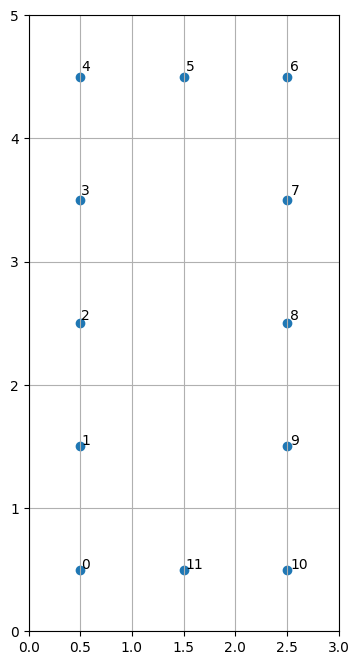

In [207]:
sg.plot_points(point_list, annotate=False, show_order=True)